In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt

from src.data_handler import load_sql_file_to_dataframe

from df_insights.modules.analyse_column_consistency import analyze_column_consistency
from df_insights.modules.save_log_to_md import save_log_to_md
from df_insights.modules.plot_histogram_distributions import plot_histogram_distribution


In [2]:
df = load_sql_file_to_dataframe(os.path.join("data","tickets.db"))

print(df.head())

SQL query executed successfully and data loaded into DataFrame.
      Ski Day valid_tickets
0  2016-12-07           112
1  2016-12-08          1769
2  2016-12-09          4230
3  2016-12-10          5952
4  2016-12-11          5451


In [3]:
consistency_report = save_log_to_md(df)
consistency_report

Possible Composite Key Found: ('Ski Day', 'valid_tickets')
Columns with Mostly Unique Values: ['Ski Day'] 

Log saved as data_analysis_log.md


c:\Users\lars_\Desktop\challenge_smart_pricer\coding-challenge-data-science-public\df_insights\modules\analyse_column_consistency.py:25: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  report_dict['Max Length'] = object_columns.applymap(lambda x: len(str(x)) if pd.notnull(x) else 0).max()
c:\Users\lars_\Desktop\challenge_smart_pricer\coding-challenge-data-science-public\df_insights\modules\analyse_column_consistency.py:26: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  report_dict['Min Length'] = object_columns.applymap(lambda x: len(str(x)) if pd.notnull(x) else 0).min()
c:\Users\lars_\Desktop\challenge_smart_pricer\coding-challenge-data-science-public\df_insights\modules\analyse_column_consistency.py:25: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  report_dict['Max Length'] = object_columns.applymap(lambda x: len(str(x)) if pd.notnull(x) else 0).max()
c:\Users\lars_\Desktop

In [4]:
"year", "month", "day", "dayofweek", "is_weekend" 

('year', 'month', 'day', 'dayofweek', 'is_weekend')

In [5]:
def get_datetime_features(df: pd.DataFrame, date_col: str) -> pd.DataFrame:
    """ Gets features out of datetime"""
    df["year"] = df[date_col].dt.year
    df["month"] = df[date_col].dt.month
    df["day"] = df[date_col].dt.day
    df["dayofweek"] = df[date_col].dt.dayofweek
    df["is_weekend"] = (df["dayofweek"] >= 5).astype(int)
    return df

def prepare_data(df: pd.DataFrame)  -> pd.DataFrame:
    """ 
    Prepare the Data for Forcasting
    Change column Names
    """
    df = df.rename(columns={"Ski Day": "dates", "valid_tickets": "valid_tickets"})
    df["dates"] = pd.to_datetime(df["dates"])
    df["valid_tickets"]  = df["valid_tickets"].astype(int)
    df = df.sort_values(by="dates")
    df = get_datetime_features(df, "dates")
    return df


def plot_data(df: pd.DataFrame, date_col: str, target: str):
    """Plots the time series data."""
    plt.figure(figsize=(12,6))
    plt.plot(df[date_col], df[target], label='Valid Tickets Sold', color='blue')
    plt.xlabel('Date')
    plt.ylabel('Tickets Sold')
    plt.title('Ski Ticket Sales Over Time')
    plt.legend()
    name = 'Ski_Ticket_Sales_Over_Time'
    plt.savefig(f"plots/{name}", dpi=300, bbox_inches='tight')
    plt.show()

df = prepare_data(df)

#plot_data(df, "dates", "valid_tickets")



In [6]:
df.groupby(["year"])["valid_tickets"].sum()

year
2016     163076
2017    1400349
2018    1462129
2019    1487118
2020    1003606
2021     168056
2022      16041
Name: valid_tickets, dtype: int64

In [7]:
df["dates"].dt.year.value_counts()

dates
2019    143
2017    139
2018    134
2020    129
2021     81
2022     32
2016     25
Name: count, dtype: int64

In [8]:
df[df["dates"].dt.year == 2017]

,dates,valid_tickets,year,month,day,dayofweek,is_weekend
25,2017-01-01,15921,2017,1,1,6,1
26,2017-01-02,17333,2017,1,2,0,0
27,2017-01-03,18008,2017,1,3,1,0
28,2017-01-04,17446,2017,1,4,2,0
29,2017-01-05,16725,2017,1,5,3,0
...,...,...,...,...,...,...,...
159,2017-12-27,14827,2017,12,27,2,0
160,2017-12-28,14615,2017,12,28,3,0
161,2017-12-29,14414,2017,12,29,4,0
162,2017-12-30,10397,2017,12,30,5,1


In [15]:
df.columns

Index(['dates', 'valid_tickets', 'year', 'month', 'day', 'dayofweek',
       'is_weekend'],
      dtype='object')

RandomForest RMSE: 8022.97
Model saved to models\RandomForest.pkl
Plot saved to plots\forecast_RandomForest.png


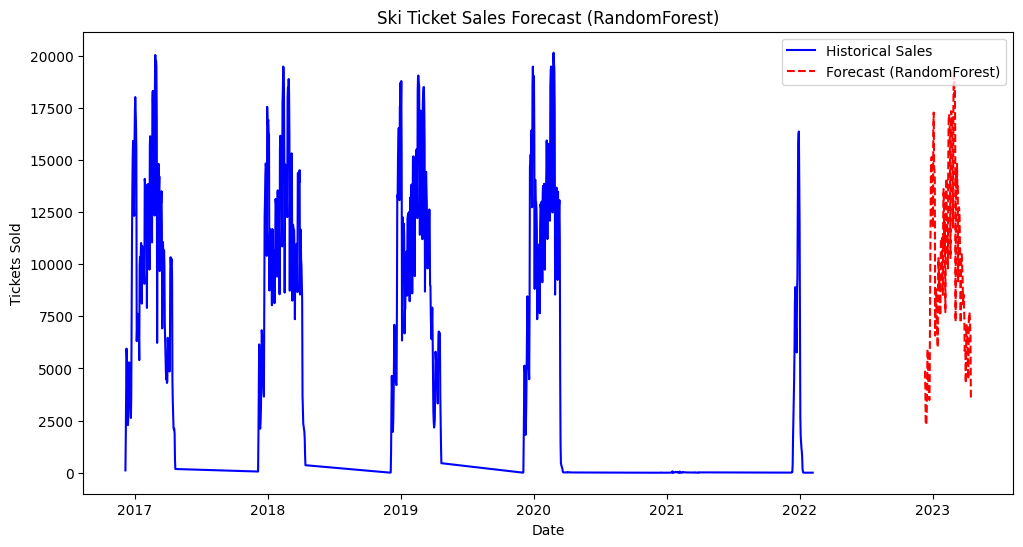

XGBoost RMSE: 7716.61
Model saved to models\XGBoost.pkl
Plot saved to plots\forecast_XGBoost.png


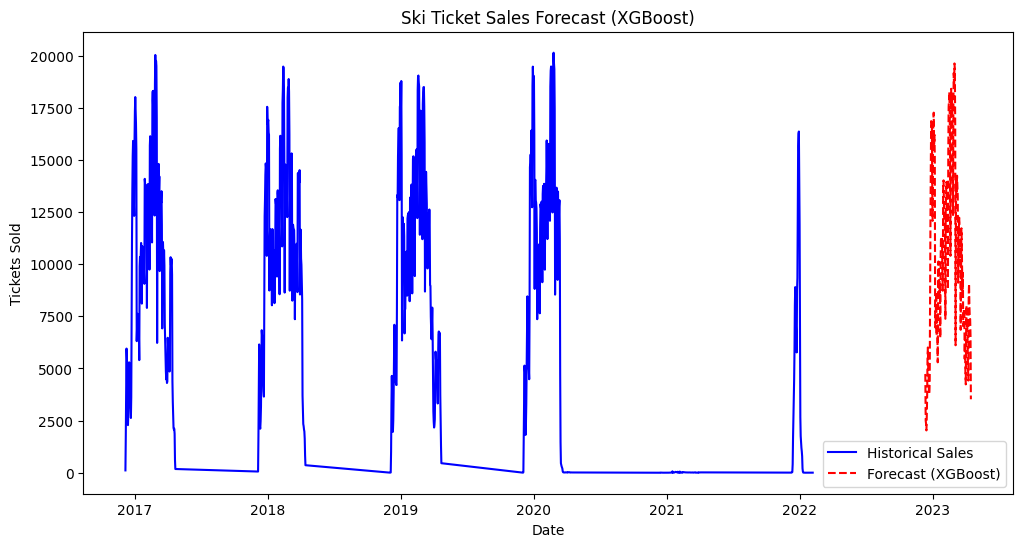

Forecasts saved to CSV.


In [27]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import joblib

def get_datetime_features(df, date_col):
    """Extract datetime features from a date column."""
    df["year"] = df[date_col].dt.year
    df["month"] = df[date_col].dt.month
    df["day"] = df[date_col].dt.day
    df["dayofweek"] = df[date_col].dt.dayofweek
    df["is_weekend"] = (df["dayofweek"] >= 5).astype(int)
    return df

def prepare_data_pred(df: pd.DataFrame) -> pd.DataFrame:
    """Prepare the Data for Forecasting."""
    df = df.rename(columns={"Ski Day": "dates", "valid_tickets": "valid_tickets"})
    df["dates"] = pd.to_datetime(df["dates"])
    df = df.sort_values(by="dates")
    df = get_datetime_features(df, "dates")
    return df

def train_and_forecast(model, model_name, df):
    """Train model and forecast future sales."""
    train = df[df["year"] < 2022]
    test = df[df["year"] == 2022]
    
    features = ["month", "day", "dayofweek", "is_weekend"]
    target = "valid_tickets"
    
    X_train, X_test = train[features], test[features]
    y_train, y_test = train[target], test[target]
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f"{model_name} RMSE: {rmse:.2f}")
    
    future_dates = pd.date_range("2022-12-10", "2023-04-15", freq="D")
    future_df = pd.DataFrame({"dates": future_dates})
    future_df = prepare_data_pred(future_df)
    future_X = future_df[features]
    
    future_df["predicted_tickets"] = model.predict(future_X)
    
    os.makedirs("models", exist_ok=True)
    os.makedirs("plots", exist_ok=True)
    
    model_path = os.path.join("models", f"{model_name}.pkl")
    joblib.dump(model, model_path)
    print(f"Model saved to {model_path}")
    
    forecast_path = os.path.join("plots", f"forecast_{model_name}.png")
    plt.figure(figsize=(12, 6))
    plt.plot(df["dates"], df["valid_tickets"], label="Historical Sales", color="blue")
    plt.plot(future_df["dates"], future_df["predicted_tickets"], label=f"Forecast ({model_name})", color="red", linestyle="dashed")
    plt.xlabel("Date")
    plt.ylabel("Tickets Sold")
    plt.title(f"Ski Ticket Sales Forecast ({model_name})")
    plt.legend()
    plt.savefig(forecast_path)
    print(f"Plot saved to {forecast_path}")
    plt.show()
    
    return future_df

rf_model = RandomForestRegressor(n_estimators=500, random_state=42)
xgb_model = xgb.XGBRegressor(n_estimators=500, learning_rate=0.05, random_state=42)

rf_forecast = train_and_forecast(rf_model, "RandomForest", df)
xgb_forecast = train_and_forecast(xgb_model, "XGBoost", df)

# Save forecasts
rf_forecast.to_csv("forecasts/ski_ticket_forecast_rf.csv", index=False)
xgb_forecast.to_csv("forecasts/ski_ticket_forecast_xgb.csv", index=False)
print("Forecasts saved to CSV.")